In [5]:
%load_ext autoreload
%autoreload

import sys
from os import path
sys.path.append(path.dirname(path.dirname(sys.path[1])))

from arch.MnistConvNet import MnistConvNet
from arch.sensitivity.GDNet import GDNet, AdditiveGDNet
from arch.sensitivity.BDNet import BDNet
from exp.loaddata_utils import load_mnist_one_image
import torch
from torch.autograd import Variable
import exp.utils_visualise as utils_visualise
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mnist_compare_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# %load parse_args_mnist
import argparse
import torch

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--dropout', type=str, default='bern',
                    help='choose from ["gauss", "bern", "add_gauss"]')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--estop_num', type=int, default=1,
                    help='early stopping at which number of alpha. Default as None')
parser.add_argument('--clip_max', type=int, default=100,
                    help='Clip at which number')
parser.add_argument('--vis_method', type=str, default='log_alpha',
                    help='By loss or log_alpha')
parser.add_argument('--epochs', type=int, default=1000, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--ard_init', type=float, default=-6.,
                    help='ARD initialization')
parser.add_argument('--reg-coef', type=float, default=0.01,
                    help='regularization coefficient')
parser.add_argument('--no-cuda', action='store_false', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--epoch-print', type=int, default=10,
                    help='how many epochs to wait before logging training status')
parser.add_argument('--edge', type=int, default=4,
                    help='Output edge*edge grid of images samples')
parser.add_argument('--save-dir', type=str, default='figs/',
                    help='Save directory')
parser.add_argument('--save-tag', type=str, default='0721-gauss',
                    help='Unique tag for output images')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)

args.cuda = not args.no_cuda and torch.cuda.is_available()
print 'cuda:', args.cuda

cuda: False


## Test Binary dropout

In [8]:
input_size = (28, 28)
trained_classifier = torch.load('../../arch/pretrained/mnist.model')

net = BDNet(input_size, trained_classifier, ard_init=args.ard_init,
              lr=args.lr, reg_coef=args.reg_coef, rw_max=30, cuda_enabled=args.cuda,
              estop_num=args.estop_num, clip_max=args.clip_max,
            flip_val=(-0.1307 / 0.3081)
            )

In [9]:
img_loader = load_mnist_one_image(img_index=None, batch_size=args.batch_size, cuda=args.cuda)
net.fit(img_loader, epochs=args.epochs, epoch_print=args.epoch_print)

epoch 9 / 1000: loss -0.07173 (-0.07186, 0.00012), acc 1.00, range: (-6.09, -5.97, -5.92)
epoch 19 / 1000: loss -0.07150 (-0.07190, 0.00040), acc 1.00, range: (-6.16, -5.91, -5.86)
epoch 29 / 1000: loss -0.07123 (-0.07190, 0.00067), acc 1.00, range: (-6.23, -5.83, -5.77)
epoch 39 / 1000: loss -0.07111 (-0.07193, 0.00082), acc 1.00, range: (-6.29, -5.74, -5.65)
epoch 49 / 1000: loss -0.07113 (-0.07195, 0.00082), acc 1.00, range: (-6.33, -5.65, -5.52)
epoch 59 / 1000: loss -0.07112 (-0.07194, 0.00082), acc 1.00, range: (-6.39, -5.56, -5.40)
epoch 69 / 1000: loss -0.07111 (-0.07193, 0.00082), acc 1.00, range: (-6.43, -5.47, -5.28)
epoch 79 / 1000: loss -0.07116 (-0.07198, 0.00082), acc 1.00, range: (-6.49, -5.38, -5.15)
epoch 89 / 1000: loss -0.07117 (-0.07198, 0.00082), acc 1.00, range: (-6.54, -5.28, -5.02)
epoch 99 / 1000: loss -0.07118 (-0.07200, 0.00082), acc 1.00, range: (-6.59, -5.18, -4.89)
epoch 109 / 1000: loss -0.07119 (-0.07201, 0.00082), acc 1.00, range: (-6.63, -5.08, -4.76)

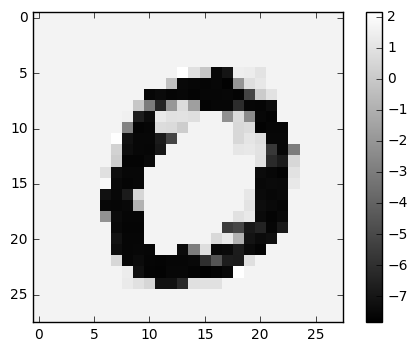

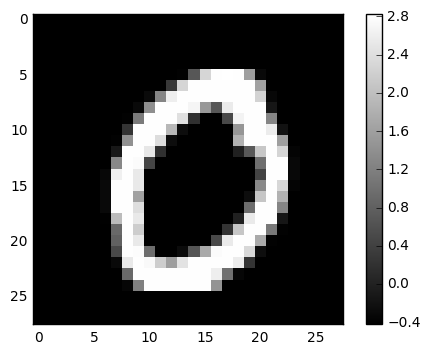

In [10]:
rank = net.get_param().data
images, labels = iter(img_loader).next()

def plot_the_img(img, cmap='gray'):
    im = plt.imshow(img, cmap=cmap, interpolation='nearest')
    plt.colorbar(im)
    plt.show()

plot_the_img(rank.numpy())
plot_the_img(images[0, 0, ...].numpy(), cmap='gray')

In [14]:
reload(mnist_compare_utils)

# Take out one mnist image and unnormalize it

logodds, order = mnist_compare_utils.calculate_logodds_diff_by_flipping(
    trained_classifier, images[0, ...], labels[0], rank, flip_val=(-0.1307 / 0.3081))

num_flip: 784
Variable containing:
1.00000e-07 *
 -7.9671
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-07 *
 -8.8781
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -1.0876
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -1.2740
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -1.2352
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -1.2870
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -1.8933
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -2.6378
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -2.7260
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -3.0343
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -4.0373
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -5.0140
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-06 *
 -5.0147
[torch.FloatTensor of size 1]

Variable co

In [18]:
np.log(1./9.)

-2.1972245773362196

In [16]:
logodds

[14.070582389831543,
 13.927481651306152,
 13.745159149169922,
 13.591009140014648,
 13.591009140014648,
 13.544488906860352,
 13.169794082641602,
 12.851340293884277,
 12.80688762664795,
 12.703703880310059,
 12.416020393371582,
 12.204710960388184,
 12.204710960388184,
 12.020405769348145,
 11.737685203552246,
 11.572927474975586,
 11.476466178894043,
 10.669363021850586,
 10.13420295715332,
 9.981332778930664,
 9.86928939819336,
 9.409969329833984,
 8.872796058654785,
 8.726615905761719,
 8.74778938293457,
 8.46513557434082,
 8.096468925476074,
 7.660696983337402,
 7.5647406578063965,
 7.5576300621032715,
 7.416325092315674,
 7.3935627937316895,
 7.007354736328125,
 6.68257474899292,
 6.63587760925293,
 6.522546291351318,
 6.164460182189941,
 6.174759864807129,
 5.926549911499023,
 5.922335624694824,
 5.7360711097717285,
 4.9540791511535645,
 4.0750932693481445,
 4.166806697845459,
 4.234744071960449,
 4.014070987701416,
 3.613868474960327,
 3.3542613983154297,
 3.436974287033081,
 

In [6]:
def plot_results(img1, img2, img1_title, img2_title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    im = ax1.imshow(img1, cmap='gray', interpolation='nearest')
    plt.colorbar(im)
    plt.title(img1_title)
    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(img2, cmap='gray', interpolation='nearest')
    plt.colorbar(im2)
    plt.title(img2_title)

    # filename = '%s/%s_debug.png' % (args.save_dir, args.save_tag)
    plt.show()
    # plt.savefig(filename, dpi=300)
    # plt.close()

In [7]:
orig_img = images[0, 0, ...].numpy()


plot_results(orig_img, flip_img, str(orig_log_odd), str(flip_log_odd))

NameError: name 'orig_img' is not defined